The InfiniteHMM class is capable of reading a GROMACS trajectory file and converting the xy coordinates to radial coordinates with respect to the pore centers. This is all done in the __init__ function. This notebook outlines how the radial coordinates are calculated.

In [3]:
import hdphmm
import mdtraj as md

First, let's load the trajectory.

In [4]:
traj = '5ms_nojump.xtc'
gro = 'em.gro'
first_frame = 7000
t = md.load(traj, top=gro)[first_frame:]

Now we will calculate the center of mass of the residue whose coordinates are being tracked

In [5]:
from hdphmm.utils import physical_properties

res = 'MET'
residue = physical_properties.Residue(res)

ndx = [a.index for a in t.topology.atoms if a.residue.name == res]
names = [a.name for a in t.topology.atoms if a.residue.name == res][:residue.natoms]  # names of atoms in one residue
mass = [residue.mass[x] for x in names]

com = physical_properties.center_of_mass(t.xyz[:, ndx, :], mass)

Now we need to locate the pore centers. The pores are not perfectly straight, so we create a spline that runs through them and is a function of z.

In [6]:
monomer = physical_properties.Residue('NAcarb11V')
pore_atoms = [a.index for a in t.topology.atoms if a.name in monomer.pore_defining_atoms and
              a.residue.name in monomer.residues]

spline_params = {'npts_spline': 10, 'save': True, 'savename': 'test_spline.pl'}

spline = physical_properties.trace_pores(t.xyz[:, pore_atoms, :], t.unitcell_vectors,
              spline_params['npts_spline'], save=spline_params['save'], savename=spline_params['savename'])[0]

Attempting to load spline ... Success!


The physical_properties module can write out the coordinates of the spline in .gro format if you'd like to compare it to the actual system.

In [7]:
physical_properties.write_spline_coordinates(spline)

Now we just need to calculate the distance between each solute center of mass and the closest spline

In [19]:
import numpy as np
import tqdm

nres = com.shape[1]
radial_distances = np.zeros([t.n_frames, nres])
npores = 4

for f in tqdm.tqdm(range(t.n_frames), unit=' Frames'):
    d = np.zeros([npores, nres])
    for p in range(npores):
        # calculate radial distance between each solute and all splines
        d[p, :] = physical_properties.radial_distance_spline(spline[f, p, ...], com[f, ...], t.unitcell_vectors[f, ...])
    
    # record distance to closest pore center
    radial_distances[f, :] = d[np.argmin(d, axis=0), np.arange(nres)]

100%|██████████| 4808/4808 [00:16<00:00, 283.14 Frames/s]


In [20]:
radial_distances.shape

(4808, 24)

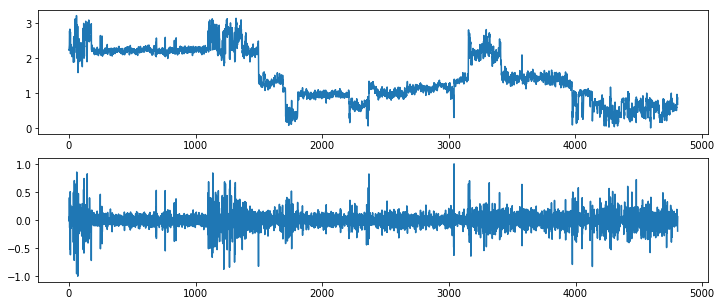

In [29]:
import matplotlib.pyplot as plt

traj_no = 2

rd = radial_distances[:, traj_no]

diff = rd[1:] - rd[:-1]

fig, ax = plt.subplots(2, 1, figsize=(12, 5))

ax[0].plot(rd)
ax[1].plot(diff)

plt.show()